In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [26]:
df = pd.read_csv("../ready_data/winter_2021.csv", index_col="ts")
# Drop columns which we are not able to get via weather forecast API
#test_df = pd.read_csv("../ready_data/test_day.csv", index_col="timestamp")


In [27]:
# Shift weather data and target variable for 12 time steps to imitate 2h weather forecast 
def add_forecasts(df):
    df['friction_fcst'] = df['Friction'].shift(periods=-12)
    df['airTemp_fcst'] = df['airTemp'].shift(periods=-12)
    df['humidity_fcst'] = df['humidity'].shift(periods=-12)
    df['dewpoint_fcst'] = df['dewpoint'].shift(periods=-12)
    df['precipitation_fcst'] = df['precipitation'].shift(periods=-12)
    #df = df.dropna()
    return df

In [28]:
df

,airTemp,humidity,dewpoint,precipitation,Friction,Road_Surface_Temperature,Water_Film_Surface_mm
ts,,,,,,,
2021-11-01 00:00:00,8.8,94.0,7.9,0.0,0.820000,5.082435,0.000000
2021-11-01 00:10:00,9.1,91.0,7.7,0.0,0.820000,5.035252,0.000000
2021-11-01 00:20:00,9.1,90.0,7.5,0.0,0.820000,4.951386,0.000000
2021-11-01 00:30:00,9.2,88.0,7.3,0.0,0.820000,5.077870,0.000000
2021-11-01 00:40:00,9.2,86.0,7.0,0.0,0.820000,4.919721,0.000000
...,...,...,...,...,...,...,...
2022-03-31 23:10:00,-3.9,87.0,-5.7,0.0,0.654679,-1.372575,0.045876
2022-03-31 23:20:00,-4.0,88.0,-5.8,0.0,0.651948,-1.649362,0.045626
2022-03-31 23:30:00,-4.3,89.0,-5.9,0.0,0.649245,-1.772748,0.045990


In [29]:
df = add_forecasts(df)


In [31]:
df

,airTemp,humidity,dewpoint,precipitation,Friction,Road_Surface_Temperature,Water_Film_Surface_mm,friction_fcst,airTemp_fcst,humidity_fcst,dewpoint_fcst,precipitation_fcst
ts,,,,,,,,,,,,
2021-11-01 00:00:00,8.8,94.0,7.9,0.0,0.820000,5.082435,0.000000,0.82,8.4,86.0,6.1,0.0
2021-11-01 00:10:00,9.1,91.0,7.7,0.0,0.820000,5.035252,0.000000,0.82,8.0,88.0,6.1,0.0
2021-11-01 00:20:00,9.1,90.0,7.5,0.0,0.820000,4.951386,0.000000,0.82,8.0,88.0,6.1,0.0
2021-11-01 00:30:00,9.2,88.0,7.3,0.0,0.820000,5.077870,0.000000,0.82,8.0,87.0,6.0,0.0
2021-11-01 00:40:00,9.2,86.0,7.0,0.0,0.820000,4.919721,0.000000,0.82,8.0,88.0,6.1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-31 23:10:00,-3.9,87.0,-5.7,0.0,0.654679,-1.372575,0.045876,NaN,NaN,NaN,NaN,NaN
2022-03-31 23:20:00,-4.0,88.0,-5.8,0.0,0.651948,-1.649362,0.045626,NaN,NaN,NaN,NaN,NaN
2022-03-31 23:30:00,-4.3,89.0,-5.9,0.0,0.649245,-1.772748,0.045990,NaN,NaN,NaN,NaN,NaN


In [9]:
# initialize DF for saving metrics
metrics_df = pd.DataFrame({
    'Metric': ['Mean Squared Error', 'Root Mean Squared Error', 'Mean Absolute Error', 'R-squared']})

In [10]:
# if you  have more than one independent variables, list them all here
# leave out the target variable! (dependent variable)
X = df.drop(["friction_fcst"], axis=1)

# have only the target variable here (dependent variable)
y = df['friction_fcst']

In [11]:
# create train and test sets of your dataset
# random_state is optional, you can lock this down in order to 
# to get same results always
# this examples reserves 30% for test data, 70% for training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

<h1>XGB</h1>

In [12]:
xgb_model = XGBRegressor(random_state=101)
xgb_model.fit(X_train, y_train)
predictions = xgb_model.predict(X_test)

mse = round(metrics.mean_squared_error(y_test, predictions), 2)
rmse = round(metrics.mean_squared_error(y_test, predictions, squared=False), 2)
mae = round(metrics.mean_absolute_error(y_test, predictions), 2)
r2 = round(metrics.r2_score(y_test, predictions), 2)

metrics_df["XGB"] = [mse, rmse, mae, r2]

metrics_df

c:\Users\kiril\Documents\GitHub\ML_project\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,Metric,XGB
0,Mean Squared Error,0.00
1,Root Mean Squared Error,0.03
2,Mean Absolute Error,0.02
3,R-squared,0.96


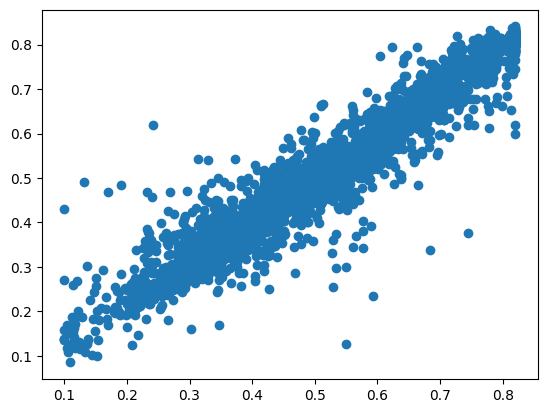

In [13]:
plt.scatter(y_test, predictions)
plt.show()

In [14]:
test_df = pd.read_csv("../ready_data/test_day.csv", index_col="ts")
test_df = add_forecasts(test_df)
test = test_df.drop("friction_fcst", axis=1)

In [32]:
result =  xgb_model.predict(test)
result

array([0.45791754, 0.45246875, 0.4511502 , 0.4430654 , 0.4430654 ,
       0.4430654 , 0.4430654 , 0.44446957, 0.44646892, 0.45101523,
       0.45101523, 0.4444706 , 0.4513334 , 0.46223742, 0.45245793,
       0.46023807, 0.45245793, 0.45245793, 0.45450544, 0.45450544,
       0.45450544, 0.45245793, 0.45208842, 0.44888633, 0.45345205,
       0.4460644 , 0.45142457, 0.4460644 , 0.45142457, 0.45142457,
       0.4453297 , 0.4453297 , 0.4453297 , 0.4453297 , 0.44810775,
       0.44964874, 0.45020384, 0.45097345, 0.45190015, 0.44600856,
       0.43946302, 0.43995354, 0.43510234, 0.43510234, 0.43510234,
       0.43510234, 0.4383709 , 0.43995354, 0.43995354, 0.44103527,
       0.4427316 , 0.44103527, 0.44306517, 0.44306517, 0.44927713,
       0.44927713, 0.46032643, 0.45962882, 0.458083  , 0.46025202,
       0.48358828, 0.49073842, 0.48637927, 0.503619  , 0.5026648 ,
       0.510883  , 0.5156855 , 0.5305191 , 0.51831275, 0.5118372 ,
       0.5118372 , 0.5118372 , 0.50485945, 0.5082242 , 0.51595

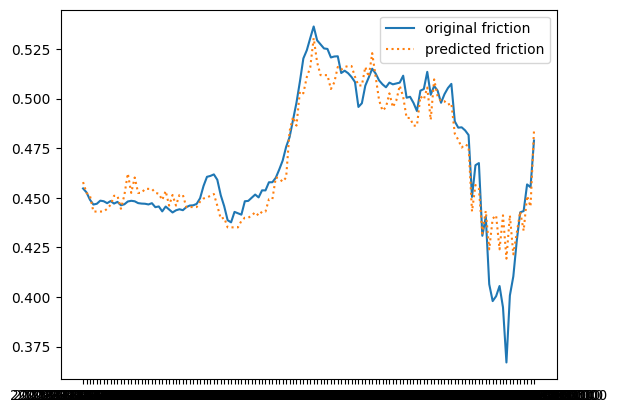

In [16]:
plt.plot(test.index, test.Friction, label="original friction")
plt.plot(test.index, result, linestyle = ":", label="predicted friction")
plt.legend()
plt.show()

<h1>XGB and Optuna</h1>

In [17]:
# 1. Wrap model training with an objective function and return accuracy
def objective(trial):
    # Suggest values of the hyperparameters using a trial object.
    # Check model's (!!! not the optuna) documentation to find out possible parameters
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'n_jobs': -1,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 2000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1)
    }
    # Model
    model = XGBRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    # Wanted metric to optimize
    rmse = metrics.mean_squared_error(y_test, predictions, squared=False)
    return rmse

In [18]:
# Create a study object and optimize the objective function.
# Directions: minimize and maximize; Trials are smth similar to epochs.
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Save best hyperparameters into variable
best_params = study.best_params
# Final model with best parameters
final_model = XGBRegressor(**best_params, random_state=101)
final_model.fit(X_train, y_train)

predictions = final_model.predict(X_test)

# Add new metrics to metrics df
mse = round(metrics.mean_squared_error(y_test, predictions), 2)
rmse = round(metrics.mean_squared_error(y_test, predictions, squared=False), 2)
mae = round(metrics.mean_absolute_error(y_test, predictions), 2)
r2 = round(metrics.r2_score(y_test, predictions), 2)

metrics_df['XGB Optuna'] = [mse, rmse, mae, r2]
metrics_df

[I 2024-12-02 14:33:36,440] A new study created in memory with name: no-name-2bb09aaa-246a-4e34-b025-eba0a3268a89
[W 2024-12-02 14:33:40,687] Trial 0 failed with parameters: {'learning_rate': 0.13323062021039517, 'n_estimators': 712, 'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.7727507392685925, 'colsample_bytree': 0.6865570353118263, 'gamma': 0.424892651363614, 'reg_alpha': 0.1135993754628748, 'reg_lambda': 0.7176079074591939} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\kiril\Documents\GitHub\ML_project\.venv\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\kiril\AppData\Local\Temp\ipykernel_18036\2496366171.py", line 21, in objective
    model.fit(X_train, y_train)
  File "c:\Users\kiril\Documents\GitHub\ML_project\.venv\Lib\site-packages\xgboost\core.py", line 575, in inner_f
    return f(**kwargs)
          

KeyboardInterrupt: 

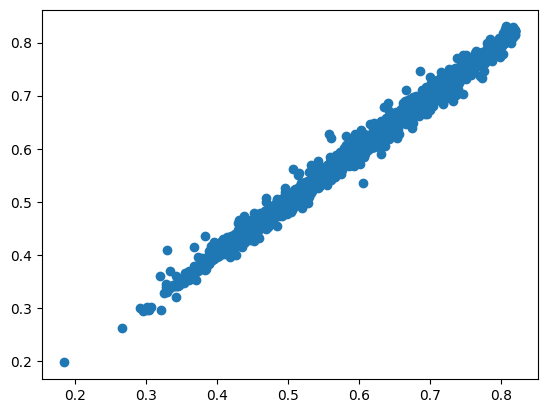

In [ ]:
plt.scatter(y_test, predictions)
plt.show()